In [1]:
import sys
import os
sys.path.append('..')

In [2]:
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Solutions
from library.solution import Solution
from library.custom.custom_solutions import WSOSolution, WSOGASolution
from library.data.relationship_matrix import relationship_matrix

# Operators
from library.algorithms.genetic_algorithms.algorithm import genetic_algorithm
from library.algorithms.genetic_algorithms.selection import fitness_proportionate_selection
from library.custom.custom_crossover import cycle_crossover, partially_matched_crossover, pos_based_crossover
from library.custom.custom_mutation import block_swap_mutation, n_swap_mutation, displacement_mutation, shuffle_subsequence_mutation
from library.custom.custom_selection import tournament_selection, ranking_selection

# Statistical Analysis
from scipy.stats import f_oneway
from library.custom.custom_stats_functions import load_fitness_results
from library.custom.custom_stats_functions import pairwise_ttest

In [3]:
pd.set_option('display.max_colwidth', None)

## Utility functions

In [52]:
def plot_fitness_over_gen(fitness_dfs: dict[str, pd.DataFrame]):
    """
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    handles, labels = [], []

    for config_name, df in fitness_dfs.items():
        mean_fitness = df.mean(axis=0)
        median_fitness = df.median(axis=0)
        
        line1, = axes[0].plot(mean_fitness.index, mean_fitness.values, label=config_name)
        axes[1].plot(median_fitness.index, median_fitness.values, label=config_name)

        handles.append(line1)
        labels.append(config_name)

    axes[0].set_title("Mean Fitness Across Generations")
    axes[1].set_title("Median Fitness Across Generations")

    for ax in axes:
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.grid(True)

    # Shared boxed legend below
    legend = fig.legend(
        handles,
        labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
        borderpad=1
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

In [16]:
# for plotting fitness results by mutation probability
def extract_mut_prob(config):
    if 'mut_prob=0.14' in config:
        return 'mut_prob=0.14'
    elif 'mut_prob=0.25' in config:
        return 'mut_prob=0.25'
    elif 'mut_prob=0.56' in config:
        return 'mut_prob=0.56'
    elif 'mut_prob=0.77' in config:
        return 'mut_prob=0.77'
    elif 'mut_prob=0.94' in config:
        return 'mut_prob=0.94'

## Global parameters

In [9]:
POP_SIZE = 50
GENERATIONS = 150 # Increased because Phase 1 didn't seem to be converging yet
NBR_RUNS = 30

## Phase 2 Experiment: Hyperparameters
Combination chosen for phase 2: partially_matched_crossover0.8_n_swap_mutation0.2_ranking_selection

In [10]:
grid_params = {
    "xo_prob": [random.uniform(0, 1/5), random.uniform(1/5, 2/5), random.uniform(2/5, 3/5), random.uniform(3/5, 4/5), random.uniform(4/5, 1)],
    "mut_prob": [random.uniform(0, 1/5), random.uniform(1/5, 2/5), random.uniform(2/5, 3/5), random.uniform(3/5, 4/5), random.uniform(4/5, 1)],
    "n_swap": [3, 6]
}

finetune_fitness_results = {}

total_configs = len(grid_params["xo_prob"]) * len(grid_params["mut_prob"]) * len(grid_params["n_swap"])
config_count = 0

for xo_prob in grid_params["xo_prob"]:
    for mut_prob in grid_params["mut_prob"]:
        for n_swap in grid_params["n_swap"]:
            config_count += 1
            print(f"Config {config_count}/{total_configs}: xo_prob={xo_prob:.2f}, mut_prob={mut_prob:.2f}, n_swap={n_swap}")

            # Create empty dataframe for each configuration
            # Columns have the fitness in each generation, rows will have results for each run
            df = pd.DataFrame(columns=range(GENERATIONS)) # Shape will be runs x gen

            for run_nr in range(NBR_RUNS):
                _, fitness_over_gens = genetic_algorithm(
                    initial_population=[
                        WSOGASolution(
                        relationship_matrix=relationship_matrix,
                        # UPDATE mutation function to best config
                        mutation_function=lambda repr, mut_prob: n_swap_mutation(repr, mut_prob=mut_prob, n=n_swap), # lambda function to pass the n_swap parameter
                        crossover_function=cycle_crossover, # UPDATE crossover function to best config
                        ) for _ in range(POP_SIZE)
                    ],
                    max_gen=GENERATIONS,
                    selection_algorithm=ranking_selection, #UPDATE selection algo to best config
                    maximization=True,
                    xo_prob=xo_prob,
                    mut_prob=mut_prob,
                    elitism=True
                )
                df.loc[run_nr] = fitness_over_gens

            # Create a label for the config
            config_label = f"xo_prob={round(xo_prob, 2)}_mut_prob={round(mut_prob, 2)}_n_swap={n_swap}"
        
            # Save configuration results in the dictionary
            finetune_fitness_results[config_label] = df

            # creating an output directory to save experiment results
            output_dir = "fitness_results/phase2"
            os.makedirs(output_dir, exist_ok=True)

            # saving each configuration result as a CSV
            df.to_csv(os.path.join(output_dir, f"{config_label}.csv"), index=False)

Config 1/50: xo_prob=0.06, mut_prob=0.14, n_swap=3
Config 2/50: xo_prob=0.06, mut_prob=0.14, n_swap=6
Config 3/50: xo_prob=0.06, mut_prob=0.25, n_swap=3
Config 4/50: xo_prob=0.06, mut_prob=0.25, n_swap=6
Config 5/50: xo_prob=0.06, mut_prob=0.56, n_swap=3
Config 6/50: xo_prob=0.06, mut_prob=0.56, n_swap=6
Config 7/50: xo_prob=0.06, mut_prob=0.77, n_swap=3
Config 8/50: xo_prob=0.06, mut_prob=0.77, n_swap=6
Config 9/50: xo_prob=0.06, mut_prob=0.94, n_swap=3
Config 10/50: xo_prob=0.06, mut_prob=0.94, n_swap=6
Config 11/50: xo_prob=0.39, mut_prob=0.14, n_swap=3
Config 12/50: xo_prob=0.39, mut_prob=0.14, n_swap=6
Config 13/50: xo_prob=0.39, mut_prob=0.25, n_swap=3
Config 14/50: xo_prob=0.39, mut_prob=0.25, n_swap=6
Config 15/50: xo_prob=0.39, mut_prob=0.56, n_swap=3
Config 16/50: xo_prob=0.39, mut_prob=0.56, n_swap=6
Config 17/50: xo_prob=0.39, mut_prob=0.77, n_swap=3
Config 18/50: xo_prob=0.39, mut_prob=0.77, n_swap=6
Config 19/50: xo_prob=0.39, mut_prob=0.94, n_swap=3
Config 20/50: xo_prob

Top 8 configurations sorted desc:
xo_prob=0.92_mut_prob=0.25_n_swap=3: 60546.666666666664
xo_prob=0.47_mut_prob=0.25_n_swap=3: 60053.333333333336
xo_prob=0.64_mut_prob=0.25_n_swap=3: 59303.333333333336
xo_prob=0.39_mut_prob=0.25_n_swap=3: 58840.0
xo_prob=0.92_mut_prob=0.56_n_swap=3: 58553.333333333336
xo_prob=0.39_mut_prob=0.14_n_swap=3: 56786.666666666664
xo_prob=0.47_mut_prob=0.56_n_swap=3: 56783.333333333336
xo_prob=0.06_mut_prob=0.25_n_swap=3: 56490.0


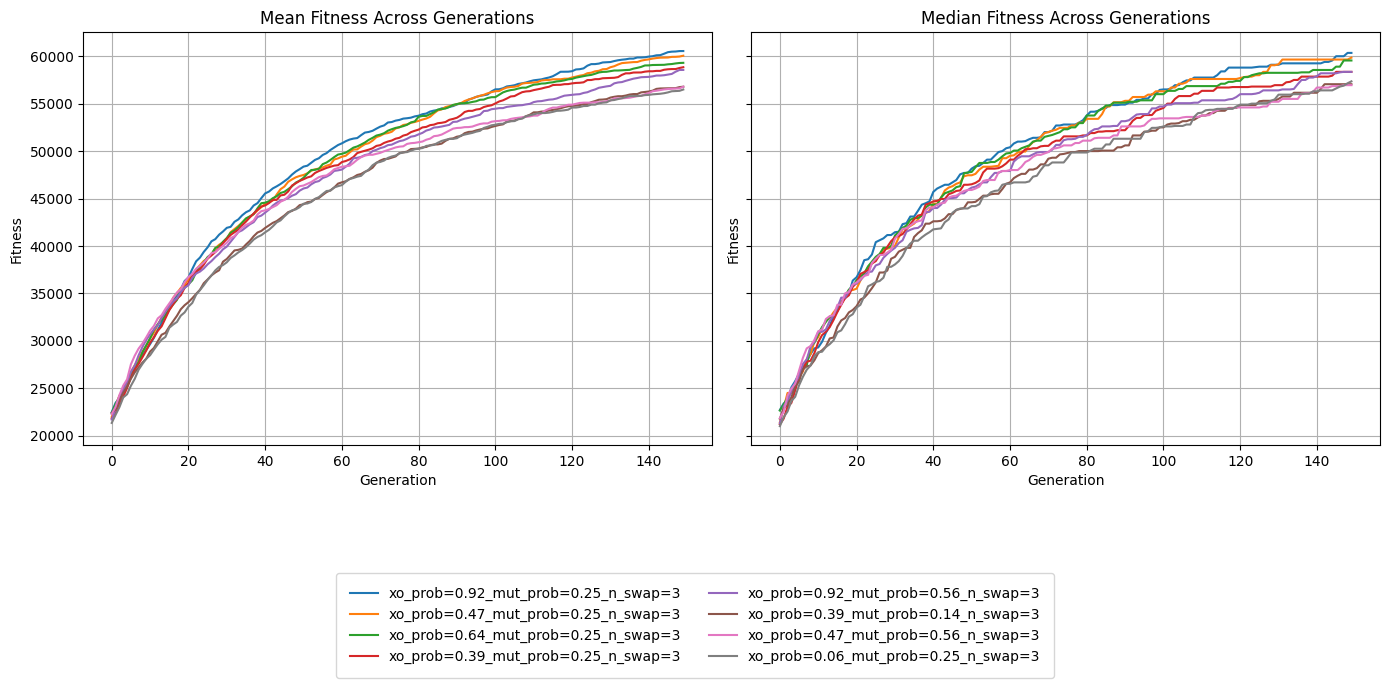

In [12]:
# Select the top 8 configurations with the highest mean fitness in the last generation
last_gen_fitness = {
    config: df[GENERATIONS - 1].mean() for config, df in finetune_fitness_results.items()
}

# Sort descending and take the top 8
top_configs = sorted(last_gen_fitness, key=last_gen_fitness.get, reverse=True)[:8]

print("Top 8 configurations sorted desc:")
for config in top_configs:
    print(f"{config}: {last_gen_fitness[config]}")

# Dictionary for plotting
top_fitness_dfs = {config: finetune_fitness_results[config] for config in top_configs}
plot_fitness_over_gen(top_fitness_dfs)

# Analysis of Experiment Results

In [4]:
# using loader function to get fitness values from CSVs (for ANOVA test)
fitness_by_configuration = load_fitness_results('fitness_results/phase2')

# using longform loader function to get fitness values from CSVs (for plotting and pairwise tests)
longform_fitness = load_fitness_results('fitness_results/phase2', longform=True)

In [5]:
# sorting configurations in descending order by highest fitness
sorted_configs = sorted(fitness_by_configuration.items(), key=lambda x: np.mean(x[1]), reverse=True)

top_sorted_configs = sorted_configs[:8]
bottom_sorted_configs = sorted_configs[-8:]

In [6]:
# print name and mean fitness of top configurations
print('Top 8 configurations:')
for config, values in top_sorted_configs:
    mean_val = sum(values) / len(values)
    print(f"{config}: mean fitness = {mean_val:.2f}")

Top 8 configurations:
xo_prob=0.92_mut_prob=0.25_n_swap=3: mean fitness = 60546.67
xo_prob=0.47_mut_prob=0.25_n_swap=3: mean fitness = 60053.33
xo_prob=0.64_mut_prob=0.25_n_swap=3: mean fitness = 59303.33
xo_prob=0.39_mut_prob=0.25_n_swap=3: mean fitness = 58840.00
xo_prob=0.92_mut_prob=0.56_n_swap=3: mean fitness = 58553.33
xo_prob=0.39_mut_prob=0.14_n_swap=3: mean fitness = 56786.67
xo_prob=0.47_mut_prob=0.56_n_swap=3: mean fitness = 56783.33
xo_prob=0.06_mut_prob=0.25_n_swap=3: mean fitness = 56490.00


In [7]:
# print name and mean fitness of bottom configurations
print('Bottom 8 configurations:')
for config, values in bottom_sorted_configs:
    mean_val = sum(values) / len(values)
    print(f"{config}: mean fitness = {mean_val:.2f}")

Bottom 8 configurations:
xo_prob=0.06_mut_prob=0.77_n_swap=6: mean fitness = 41333.33
xo_prob=0.64_mut_prob=0.77_n_swap=6: mean fitness = 40873.33
xo_prob=0.92_mut_prob=0.77_n_swap=6: mean fitness = 40690.00
xo_prob=0.06_mut_prob=0.94_n_swap=6: mean fitness = 40006.67
xo_prob=0.39_mut_prob=0.94_n_swap=6: mean fitness = 39483.33
xo_prob=0.47_mut_prob=0.94_n_swap=6: mean fitness = 38963.33
xo_prob=0.64_mut_prob=0.94_n_swap=6: mean fitness = 38173.33
xo_prob=0.92_mut_prob=0.94_n_swap=6: mean fitness = 37940.00


### Visualization of Final Best Configuration

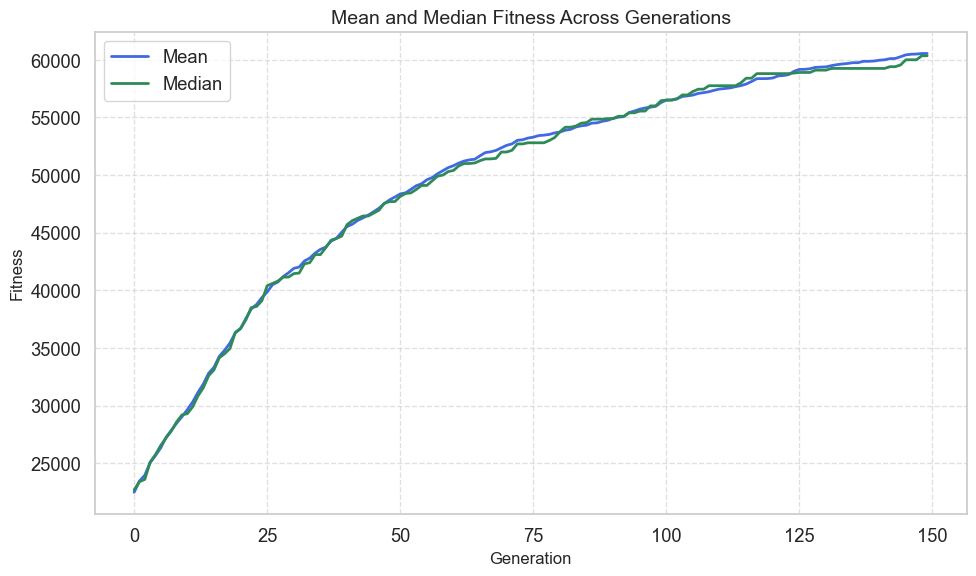

In [21]:
best_fitness_df = pd.read_csv("fitness_results/phase2/xo_prob=0.92_mut_prob=0.25_n_swap=3.csv")

best_fitness_df.columns = best_fitness_df.columns.astype(int)

# computing mean and median across runs (rows)
mean_fitness = best_fitness_df.mean(axis=0)
median_fitness = best_fitness_df.median(axis=0)

plt.figure(figsize=(10, 6))

plt.plot(mean_fitness.index, mean_fitness.values, label="Mean", color='royalblue', linewidth=2)
plt.plot(median_fitness.index, median_fitness.values, label="Median", color='seagreen', linewidth=2)

# Customize
plt.title("Mean and Median Fitness Across Generations", fontsize=14)
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Fitness", fontsize=12)
plt.xticks(range(0, 151, 25))  # Tick every 25 generations
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


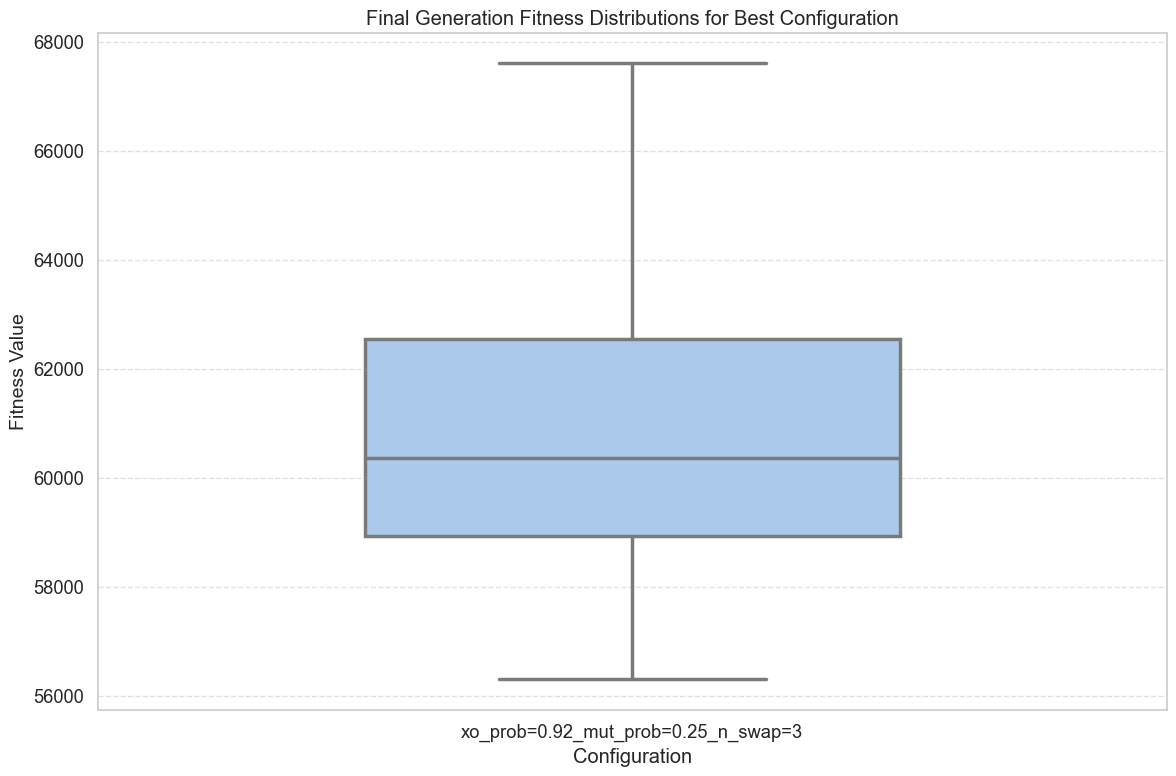

In [22]:
# Set a beautiful theme using Seaborn
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

# Create the plots - one for each selection method for readibility
plt.figure(figsize=(12, 8))
data = longform_fitness[longform_fitness['configuration'] == 'xo_prob=0.92_mut_prob=0.25_n_swap=3']

ax = sns.boxplot(x='configuration', y='fitness_value', data=data, width=0.5, linewidth=2.5, fliersize=4)

# Titles and labels
plt.title(f'Final Generation Fitness Distributions for Best Configuration')
plt.ylabel('Fitness Value', fontsize=14)
plt.xlabel('Configuration')
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## Statistical Analysis  

Similar to with Phase 1, we will conduct an ANOVA and post-hoc test to determine statistical significance of our results. Assumptions for these tests are satisfied in the same manner as Phase 1.

### Examining fitness distributions among configurations  

Before running our ANOVA test, we will examine the distributions of mean final generation fitness in our configurations. Visualizations are plotted by mutation probability.

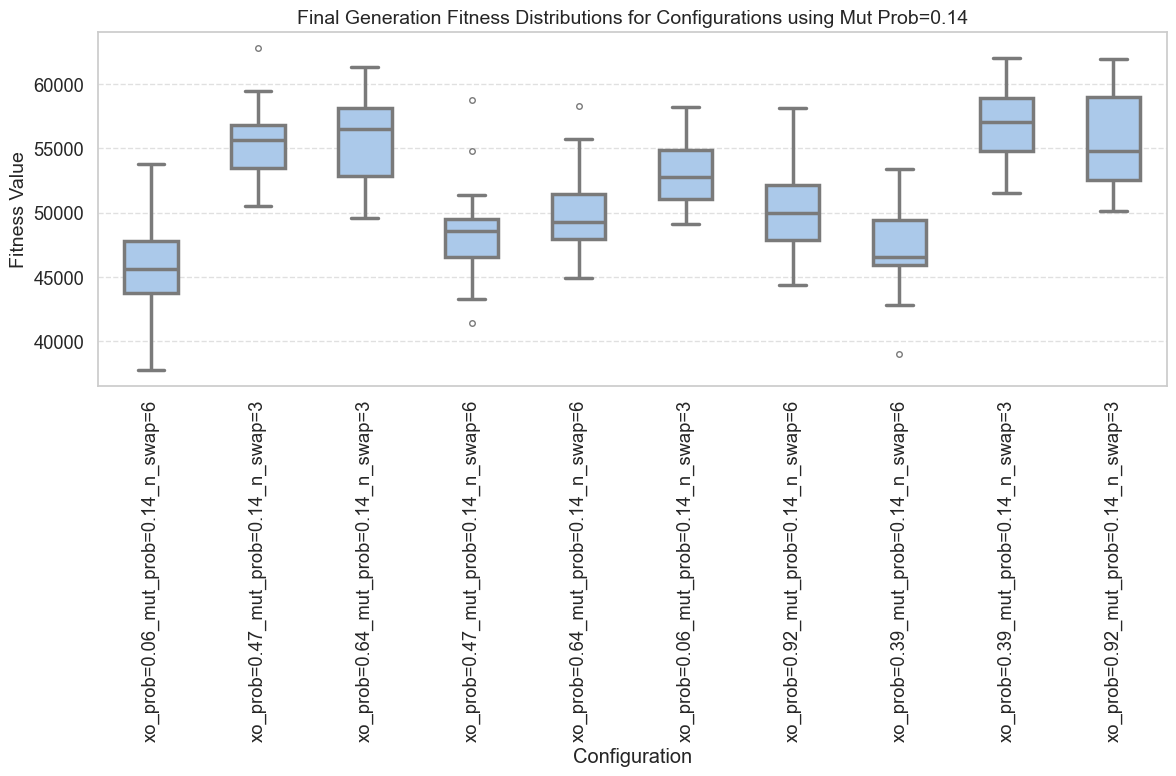

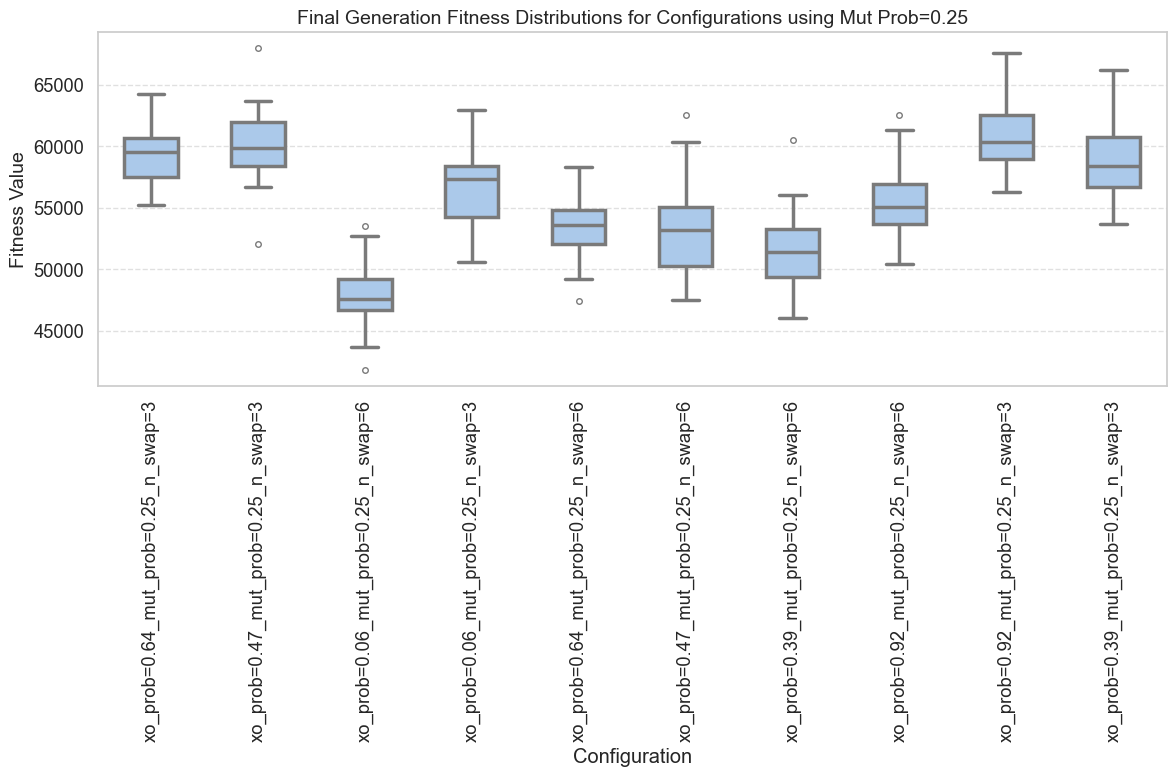

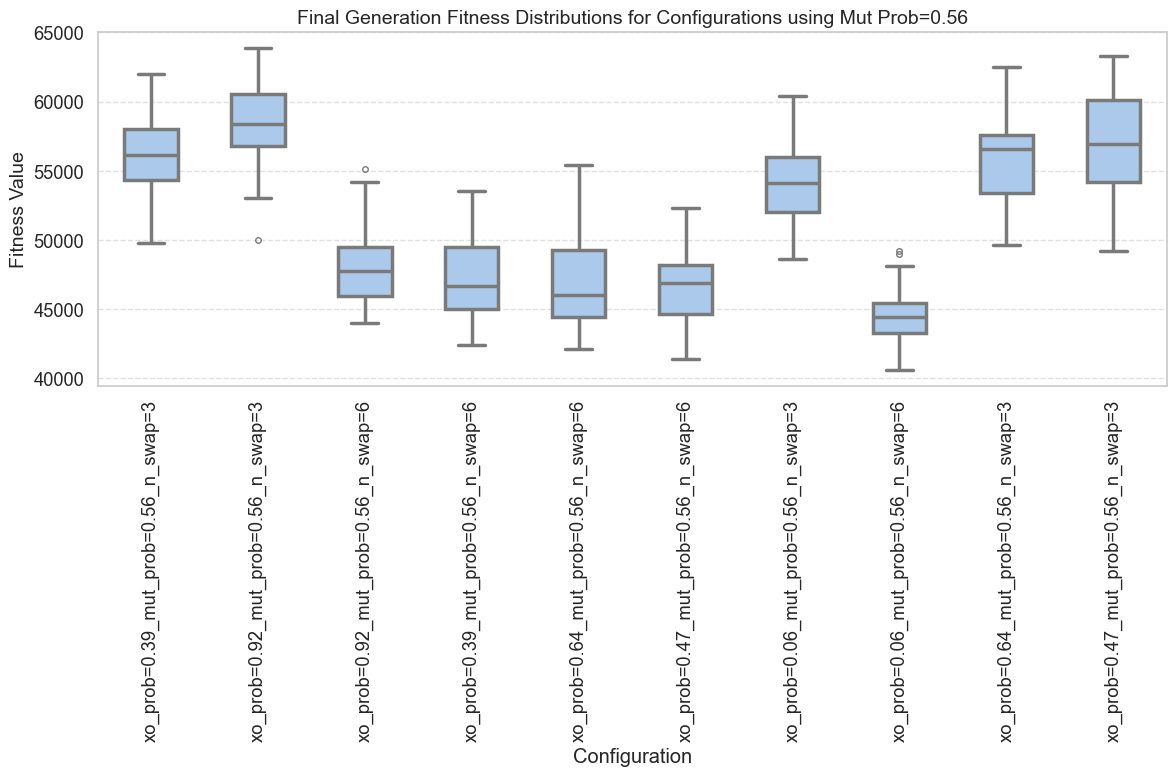

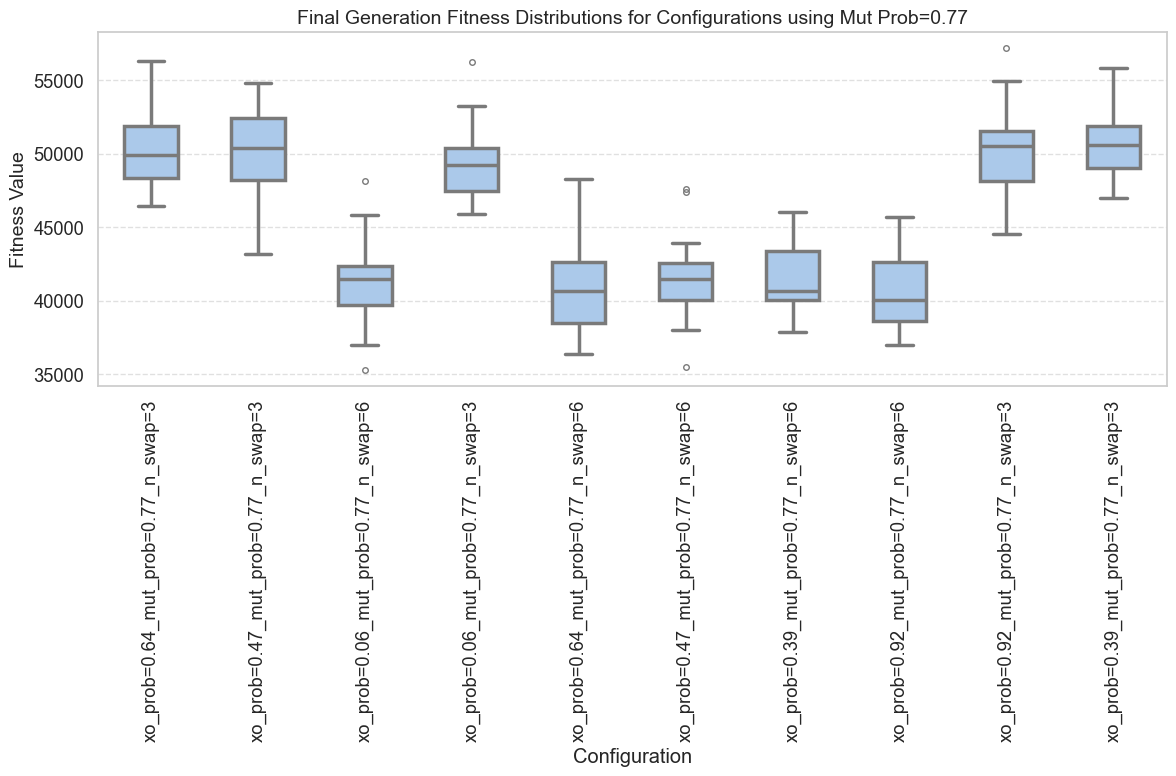

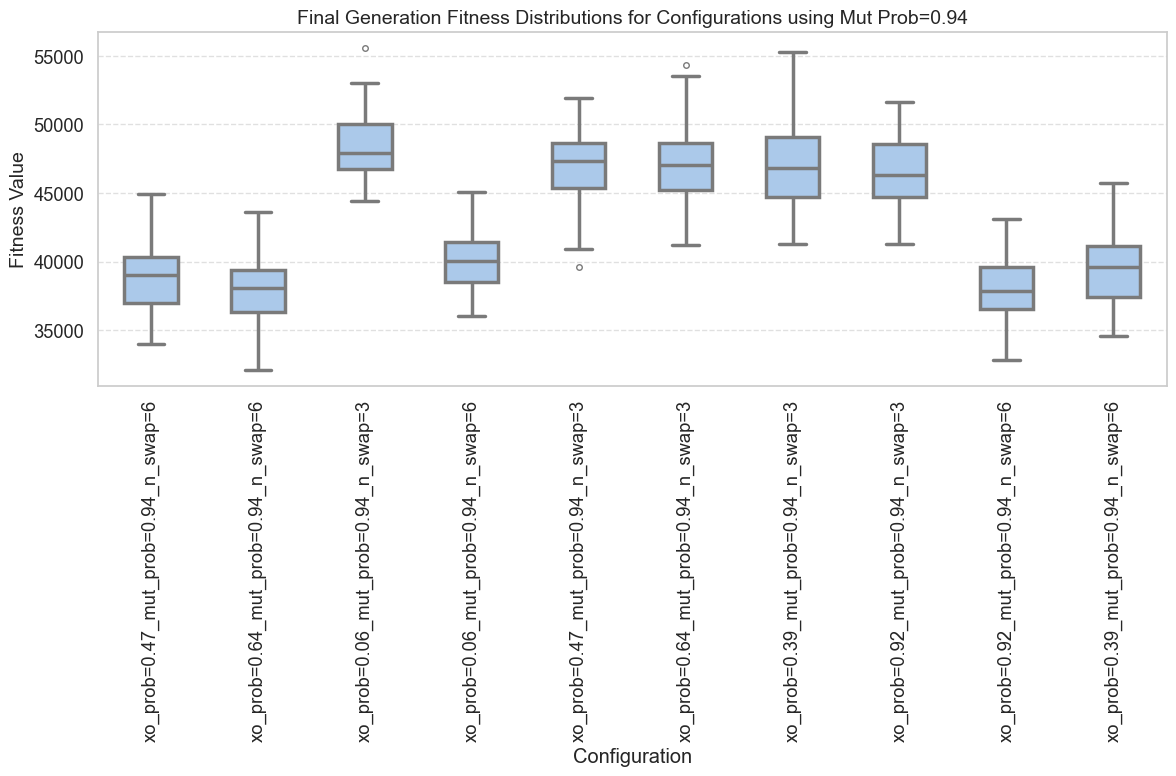

In [24]:
# Set a beautiful theme using Seaborn
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

longform_fitness['mut_prob'] = longform_fitness['configuration'].apply(extract_mut_prob)

# Create the plots - one for each selection method for readibility
for prob in sorted(longform_fitness['mut_prob'].unique()):
    plt.figure(figsize=(12, 8))
    data_subset = longform_fitness[longform_fitness['mut_prob'] == prob]

    ax = sns.boxplot(x='configuration', y='fitness_value', data=data_subset, width=0.5, linewidth=2.5, fliersize=4)

    # Titles and labels
    plt.title(f"Final Generation Fitness Distributions for Configurations using {prob.replace('_', ' ').title()}", fontsize=14)
    plt.ylabel('Fitness Value', fontsize=14)
    plt.xlabel('Configuration')
    plt.xticks(rotation=90)
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

### Boxplot Analysis

#### Visual observations  
Visual analysis of the boxplots of fitness values reveal a few important trends:
- Configurations with n = 6 (6 pairs of swaps in N-Swap Mutation) perform significantly worse than configurations where n = 3. This is likely because 6 swaps is a highly destructive mutation.
- Configurations with high mutation probabilities (0.77 and 0.94) perform worse than those with lower mutation probabilities. This is also likely due to the fact that mutating more individuals increases the chances that valuable traits will be destroyed and not carried on into a new population.
- Configurations with mutation probability of 0.25 have the overall highest performance. This value seems to be valuable in introducing diversity to our solution population without being overly disruptive
- Crossover probabilities do not appear to have a significant impact on the distribution of fitness values.


#### Implications for statistical tests  
Distributions of the fitness values of the configurations tested in Phase 2 are less normally distributed than those in Phase 1, likely due to the lower sample size. However, as each configuration has a 30 observations, it is still safe to assume normality. IQRs are more variable, and it is difficult to make assumptions about the distribution of standard deviations. Despite this, we will continue with our ANOVA test.

### ANOVA difference in means test

In [8]:
# performing ANOVA test of difference in means among multiple groups

# converts fitness values of each config into a list for ANOVA
groups = list(fitness_by_configuration.values())

# ANOVA test
f_stat, p_value = f_oneway(*groups)

print('F-statistic:', f_stat)
print('p-value:', p_value)

# interpreting results:
if p_value <= 0.05:
    print('There is statistical evidence to suggest that the mean final genertion fitness of at least one configuration is different than the others.')
else:
    print('There is no statistical evidence to suggest that the mean final genertion fitness of one configuration is different than the others.')

F-statistic: 140.59602687471906
p-value: 0.0
There is statistical evidence to suggest that the mean final genertion fitness of at least one configuration is different than the others.


### Pos-Hoc tests for ANOVA: Pairwise T-Test  
The following test is to determine if the mean final geneartion fitness of our best perfomring configuration (xo_prob=0.92_mut_prob=0.25_n_swap=3) is statistically significantly higher than other configurations we tested. Using ScipyStats t-test, we conduct a pairwise test on our best configuration against all others. A p-value of 0.05/50 = 0.001 is used to adjust for the increased probability of a Type I error when running multiple pairwise t-tests.

In [9]:
# performing post-hoc pairwise t-test between best configuration and all others
phase2_ttest_best = pairwise_ttest(longform_fitness, 'xo_prob=0.92_mut_prob=0.25_n_swap=3', 0.001)
phase2_ttest_best

,compared_to,mean_best,mean_other,mean_diff,p_value,significant
15,xo_prob=0.92_mut_prob=0.94_n_swap=6,60546.666667,37940.000000,22606.666667,2.512206e-42,True
2,xo_prob=0.64_mut_prob=0.94_n_swap=6,60546.666667,38173.333333,22373.333333,1.847112e-40,True
6,xo_prob=0.06_mut_prob=0.94_n_swap=6,60546.666667,40006.666667,20540.000000,1.404608e-39,True
1,xo_prob=0.47_mut_prob=0.94_n_swap=6,60546.666667,38963.333333,21583.333333,4.352921e-39,True
39,xo_prob=0.39_mut_prob=0.77_n_swap=6,60546.666667,41533.333333,19013.333333,2.723045e-38,True
18,xo_prob=0.39_mut_prob=0.94_n_swap=6,60546.666667,39483.333333,21063.333333,3.588154e-38,True
41,xo_prob=0.92_mut_prob=0.77_n_swap=6,60546.666667,40690.000000,19856.666667,9.010477e-38,True
36,xo_prob=0.47_mut_prob=0.77_n_swap=6,60546.666667,41510.000000,19036.666667,2.267538e-37,True
27,xo_prob=0.06_mut_prob=0.77_n_swap=6,60546.666667,41333.333333,19213.333333,1.395606e-36,True
35,xo_prob=0.64_mut_prob=0.77_n_swap=6,60546.666667,40873.333333,19673.333333,2.122258e-35,True


In [10]:
# examining configurations that are NOT statistically different from best configuration
phase2_ttest_best[phase2_ttest_best['significant'] == False]

,compared_to,mean_best,mean_other,mean_diff,p_value,significant
3,xo_prob=0.92_mut_prob=0.56_n_swap=3,60546.666667,58553.333333,1993.333333,0.004637,False
47,xo_prob=0.39_mut_prob=0.25_n_swap=3,60546.666667,58840.000000,1706.666667,0.012753,False
21,xo_prob=0.64_mut_prob=0.25_n_swap=3,60546.666667,59303.333333,1243.333333,0.029794,False
24,xo_prob=0.47_mut_prob=0.25_n_swap=3,60546.666667,60053.333333,493.333333,0.243018,False
45,xo_prob=0.92_mut_prob=0.25_n_swap=3,60546.666667,60546.666667,0.000000,0.500000,False


### Statistical Conclusion

The mean of our best performing configuration (xo_prob=0.92_mut_prob=0.25_n_swap=3) is statistically significantly higher than nearly all our other configurations. There are four configuration that have similar performance. Three of four have nearly the same configuration as our top performing configuration, with a difference only in the crossover probability. This aligns with our observations from the boxplots, which indicated that crossover probability did not have a noticable effect on distribution of fitness values. We can conclude that, while our best configuration is not statistically different from ALL other configurations, it is still a well-perfomring configuration.

# Checking best solution

In [ ]:
df_results = pd.DataFrame(fitness_by_configuration)

In [ ]:
df_results

,xo_prob=0.06_mut_prob=0.14_n_swap=3,xo_prob=0.06_mut_prob=0.14_n_swap=6,xo_prob=0.06_mut_prob=0.25_n_swap=3,xo_prob=0.06_mut_prob=0.25_n_swap=6,xo_prob=0.06_mut_prob=0.56_n_swap=3,xo_prob=0.06_mut_prob=0.56_n_swap=6,xo_prob=0.06_mut_prob=0.77_n_swap=3,xo_prob=0.06_mut_prob=0.77_n_swap=6,xo_prob=0.06_mut_prob=0.94_n_swap=3,xo_prob=0.06_mut_prob=0.94_n_swap=6,...,xo_prob=0.92_mut_prob=0.14_n_swap=3,xo_prob=0.92_mut_prob=0.14_n_swap=6,xo_prob=0.92_mut_prob=0.25_n_swap=3,xo_prob=0.92_mut_prob=0.25_n_swap=6,xo_prob=0.92_mut_prob=0.56_n_swap=3,xo_prob=0.92_mut_prob=0.56_n_swap=6,xo_prob=0.92_mut_prob=0.77_n_swap=3,xo_prob=0.92_mut_prob=0.77_n_swap=6,xo_prob=0.92_mut_prob=0.94_n_swap=3,xo_prob=0.92_mut_prob=0.94_n_swap=6
0,52600,48400,58500,47700,55000,46000,48400,42100,50700,45100,...,54600,49000,59600,56600,60900,47400,50600,37800,43300,39300
1,54300,40600,58000,47200,53900,45200,52700,41300,46400,43900,...,59600,48100,57100,54800,63500,48800,47000,40500,46100,41200
2,49100,44000,62900,48600,51700,44100,47300,42000,47900,41000,...,51700,53200,58300,55700,53900,44900,46200,43800,43800,43100
3,56200,48500,58700,47000,51600,43900,50000,40700,46100,38800,...,61900,49800,62900,59300,63200,47500,50600,38400,46100,36500
4,57600,43400,50600,49200,58400,43300,56200,42400,48200,39800,...,59200,49600,59700,50400,58700,50600,50700,40000,49900,37200
5,49700,48000,55800,46300,53500,45500,50100,43700,53000,39900,...,58600,47100,59000,54600,56700,52900,49200,41200,49000,39700
6,58200,46600,60400,51200,55100,44900,50300,39000,49400,38300,...,52600,47500,61200,52900,58300,48000,53500,38600,45200,40000
7,55300,53800,57900,50400,59000,40800,46500,41500,52000,40000,...,52500,50500,57200,56000,55500,48700,51100,42800,46500,37500
8,53500,53200,54200,43800,53800,44800,48200,41200,45600,41600,...,61900,57600,60400,59100,58400,48900,44500,44200,51600,38000
9,54900,42700,53700,51700,55800,41300,47000,37500,47900,36600,...,59000,53100,58500,54900,57600,49500,54900,44800,41300,36400


In [ ]:
idxmax = df_results.stack().idxmax()
print(f"Max value at row {idxmax[0]}, column {idxmax[1]}: {df.loc[idxmax]}")

Max value at row 6, column xo_prob=0.47_mut_prob=0.25_n_swap=3: 68000


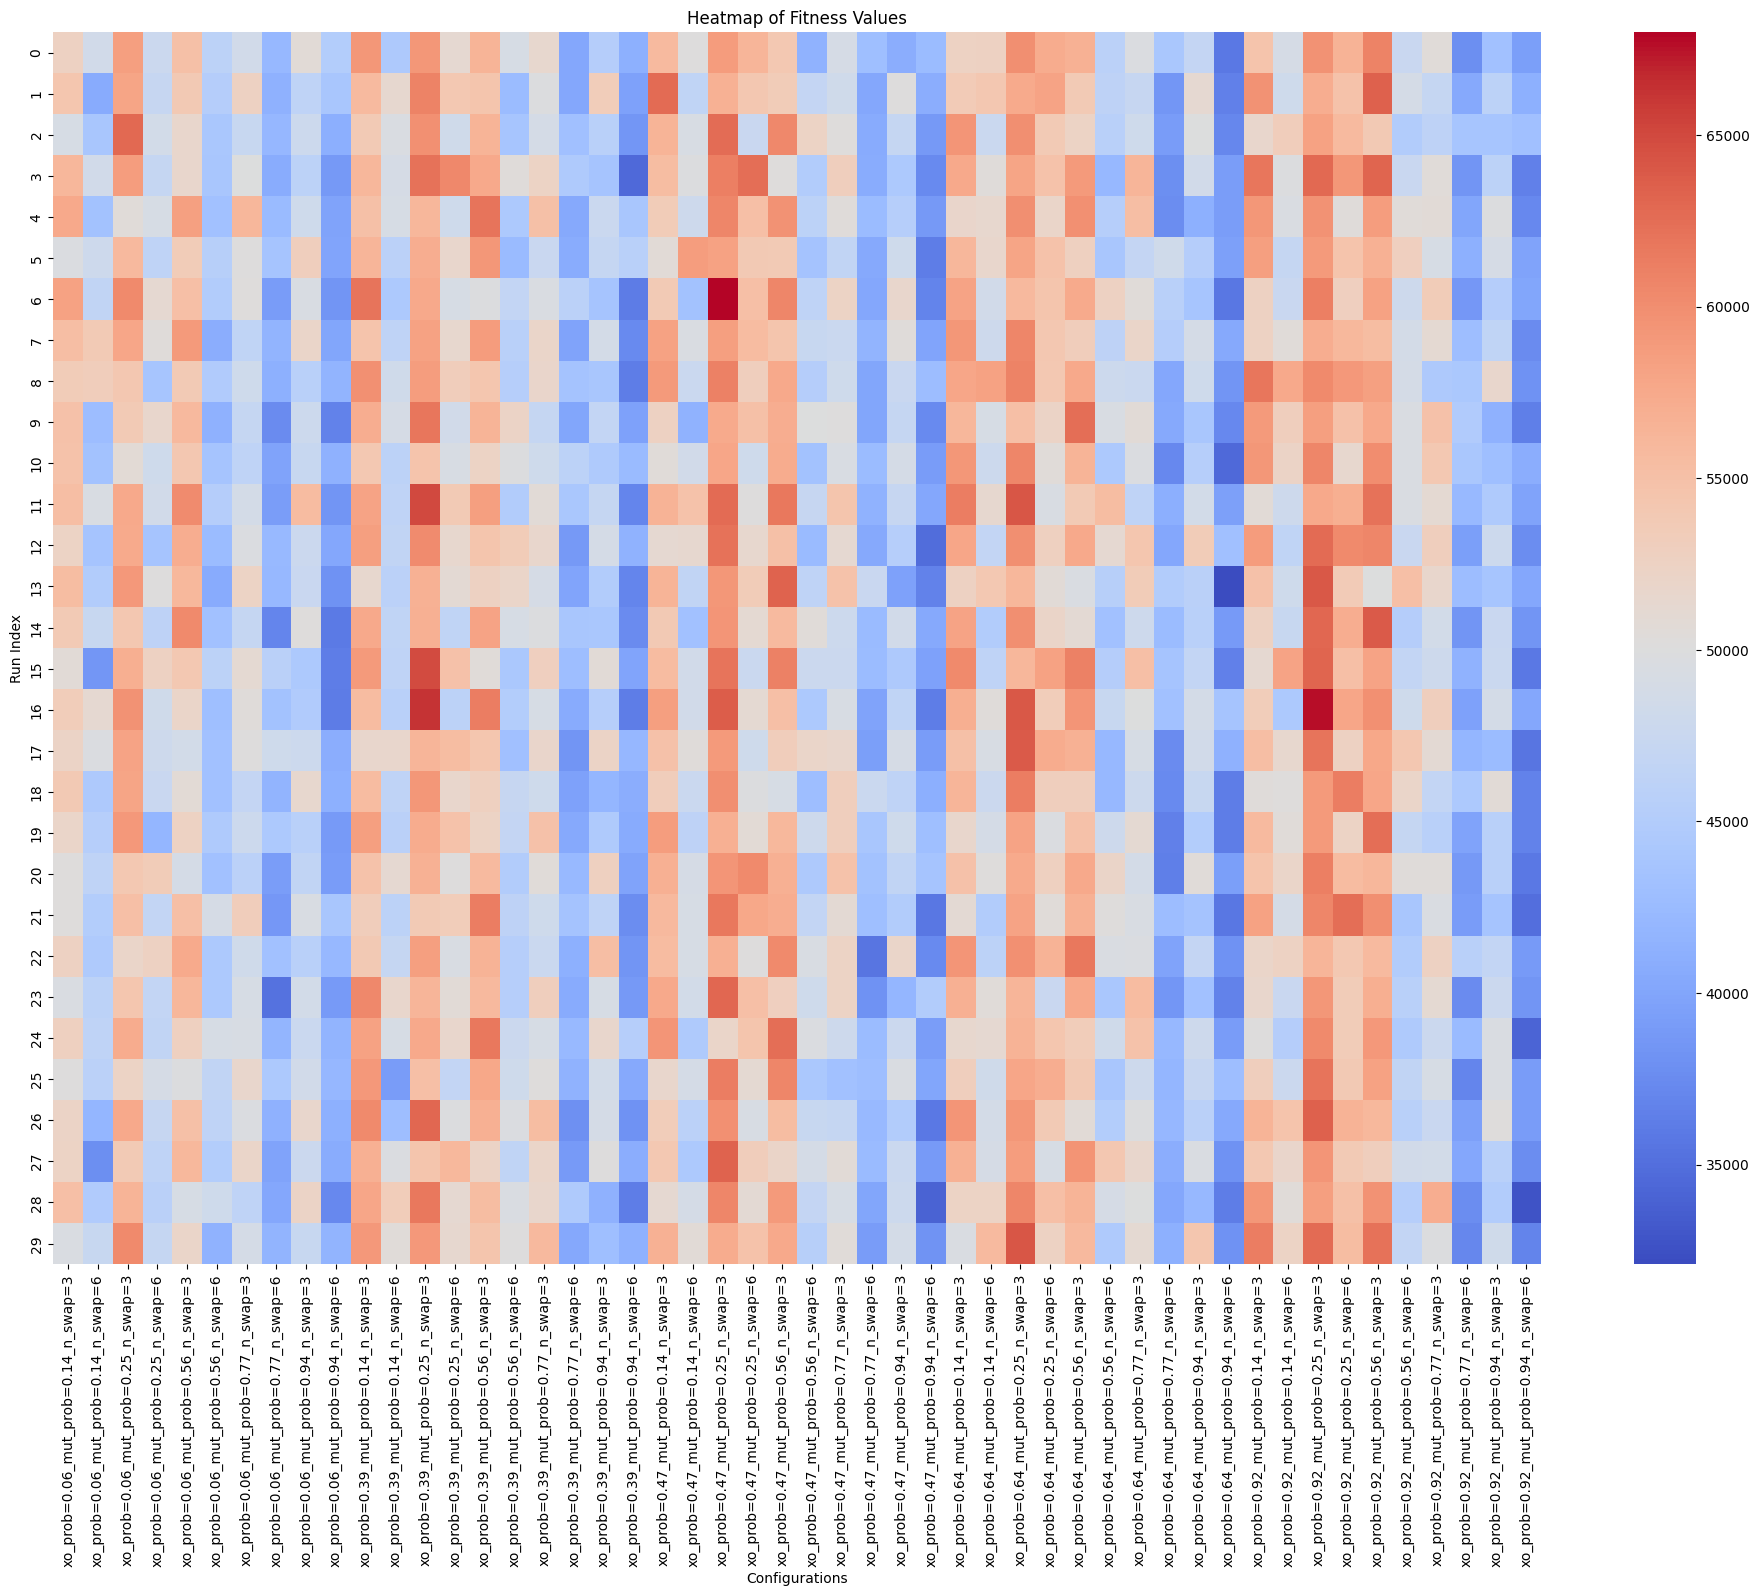

In [ ]:
plt.figure(figsize=(24, 16))
sns.heatmap(df, annot=False, fmt='d', cmap='coolwarm')
plt.title('Heatmap of Fitness Values')
plt.xlabel('Configurations')
plt.ylabel('Run Index')
plt.show()